<a href="https://colab.research.google.com/github/mb8655/Python/blob/main/Pandas-vs-SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Using Python/Pandas together with SQL

In [1]:
#Setup the environment

!sudo pip3 install -U -q PyMySQL sqlalchemy


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Change the graph defaults
plt.rcParams['figure.figsize'] = (6, 2)  # Default figure size of 6x2 inches
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['font.size'] = 12  # Default font size of 12 points
plt.rcParams['lines.linewidth'] = 1  # Default line width of 1 points
plt.rcParams['lines.markersize'] = 3  # Default marker size of 3 points
plt.rcParams['legend.fontsize'] = 10  # Default legend font size of 10 points


from sqlalchemy import create_engine
from sqlalchemy import text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 216.0 kB/s eta 0:00:00


#Importing SQL results into DataFrames using read_sql
The read_sql function of Pandas allows us to create a dataframe directly from a SQL query. To execute the query, we first setup the connection to the database using the SQLAlchemy library.

In [2]:
conn_string_imdb = 'mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
    user='student',
    password='dwdstudent2025',
    host = 'db.ipeirotis.org',
    port=3306,
    db='imdb',
    encoding = 'utf-8'
)
engine_imdb = create_engine(conn_string_imdb)

In [3]:
#Create simple SQL query, and get back the results loaded in a dataframe.

query = '''
SELECT * FROM actors LIMIT 10
'''

with engine_imdb.connect() as connection:
  df_actors = pd.read_sql(text(query), con=connection)

df_actors


,id,first_name,last_name,gender
0,2,Michael,'babeepower' Viera,M
1,3,Eloy,'Chincheta',M
2,4,Dieguito,'El Cigala',M
3,5,Antonio,'El de Chipiona',M
4,6,José,'El Francés',M
5,7,Félix,'El Gato',M
6,8,Marcial,'El Jalisco',M
7,9,José,'El Morito',M
8,10,Francisco,'El Niño de la Manola',M
9,11,Víctor,'El Payaso',M


In [4]:
#we can see that the limit of 10 infact was enforced by using the len()

len(df_actors)


10

##Fetch all data, analyze in Pandas
Let's do the simple thing first. We will fetch all the data from the movies table and then do a pivot table on top. Since we care about efficiency, we will also time the operation.

In [5]:
# the time function below Shows that it takes 2-3 seconds to fetch the data from SQL and create the dataframe, as we need to fetch almost 400K records.

%%time
query = '''SELECT * FROM movies'''
with engine_imdb.connect() as conn:
  df_basic = pd.read_sql(text(query), con=conn)

len(df_basic)

CPU times: user 5.07 s, sys: 579 ms, total: 5.65 s
Wall time: 13.4 s


388269

In [6]:
#create a  a pivot table:

%%time
# Counting movie IDs returns all the movies within the year
# Counting movie ranks returns all the movies that have
# a non-empty "rank" value (i.e., they have been rated)
pivot = df_basic.pivot_table(
    index = 'year',
    aggfunc = 'count',
    values = ['id', 'rating']
)
# Rename the columns
pivot.columns = ['all_movies', 'rated_movies']

CPU times: user 21 ms, sys: 122 µs, total: 21.1 ms
Wall time: 54.8 ms


In [7]:
# And let's check a few lines of the table
pivot.sample(5)

,all_movies,rated_movies
year,,
1926,2137,119
1928,2051,125
1924,1847,68
1888,2,0
1942,1902,497


<Axes: xlabel='year'>

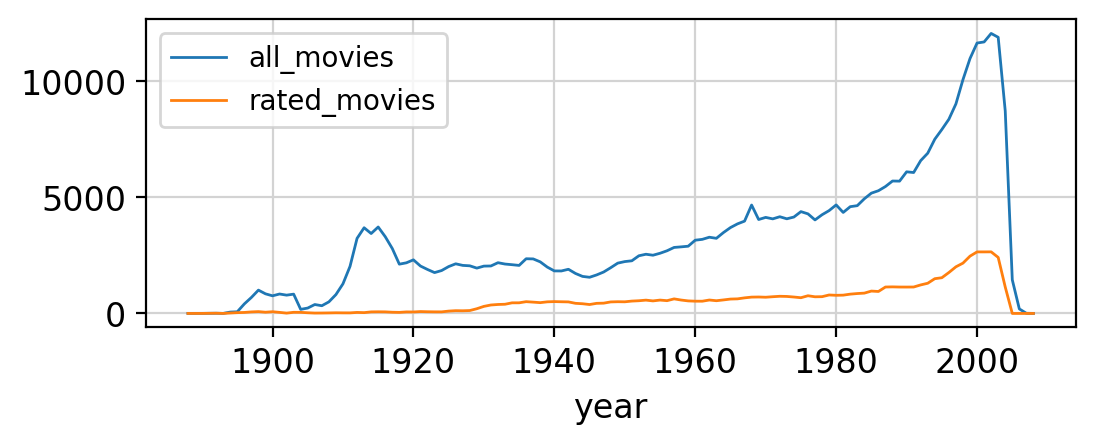

In [8]:
#graph the results
pivot.plot()

#Aggregation in SQL, fetch only necessary data
Now let's push the computation on the SQL server instead, using a GROUP BY and COUNT aggregates in SQL.

***Notice that the same calculation was done in a few (4-5) milliseconds. The SQL query that we used earlier it took seconds to execute. In fact, the pivot table calculation, executed after fetching all the data took longer than executing the GROUPBY/COUNT SQL query and fetching the results.

In [9]:
%%time
query = '''
SELECT year, COUNT(*) AS all_movies, COUNT(rating) AS rated_movies
FROM movies
GROUP BY year
ORDER BY year
'''
with engine_imdb.connect() as conn:
  df_movies = pd.read_sql(text(query), con=conn)

CPU times: user 7.94 ms, sys: 1.84 ms, total: 9.78 ms
Wall time: 248 ms


plot the results. In pandas, the simple plot() command will use the index as the x-axis, and will plot all the numeric columns, as a line plot.

<Axes: >

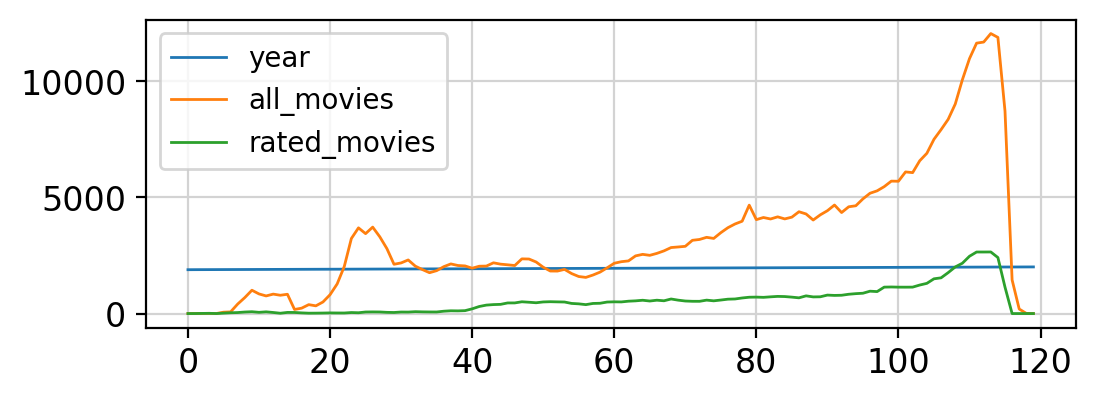

In [10]:
# The plot() command takes the index (the first "column") of the dataframe
# and makes that the x-axis.
# Then it plots *ALL* the numeric columns as a line
df_movies.plot()

<Axes: xlabel='year'>

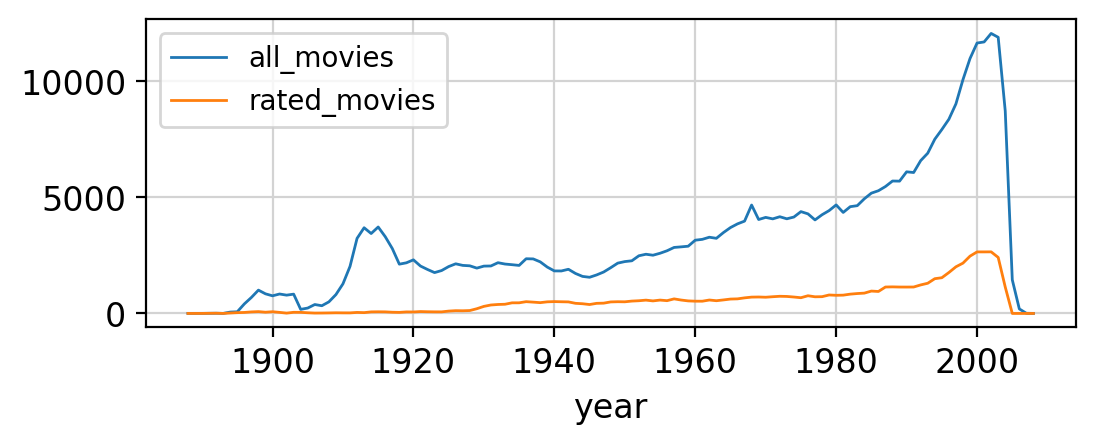

In [11]:
#We do not want to plot the year variable as a line. So, we select just the other two columns and plot.
# First step: We can assign "year" to the x-axis
# and list for the y-axis the the columns that we want to plot
# (we can actually skip listing the columns for the y-axis,
# pandas will plot all numeric columns)
df_movies.plot(
    kind = 'line', # optional, as kind='line' by default
    x = 'year',
    y = ["all_movies", "rated_movies"]
)


Changing data types: Int vs Datetime
In our analysis above, the "year" variable is an integer:

In [12]:
# view datatypes

df_movies.dtypes


,0
year,int64
all_movies,int64
rated_movies,int64


In [13]:
#use the time series processing capabilities of Pandas by converting year to a date.
df_movies['year'] = pd.to_datetime(df_movies['year'], format='%Y')
df_movies.dtypes


,0
year,datetime64[ns]
all_movies,int64
rated_movies,int64


In [14]:
df_movies.sample(5)


,year,all_movies,rated_movies
71,1960-01-01,3154,528
57,1946-01-01,1658,435
75,1964-01-01,3482,582
66,1955-01-01,2591,575
100,1989-01-01,5697,1137


<Axes: xlabel='year'>

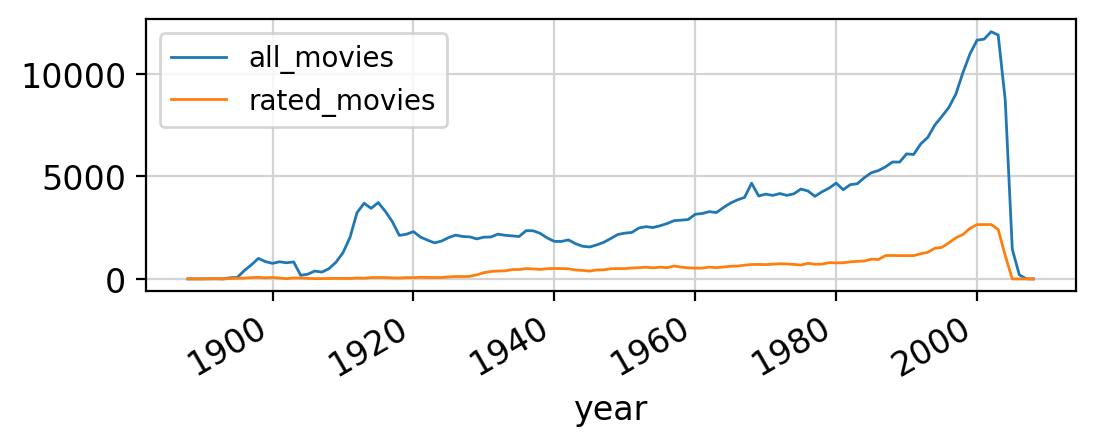

In [15]:
df_movies.plot(
    x = 'year'
)

In [16]:
#Now we can also put year in the index andresample the dates in the index. For example, we can compute numbers over 5-year periods:
(
    df_movies
    .set_index('year') # need to make year an index to do resampling
    .resample('5Y') # calculate stats over 5-year periods
    .sum() # total number of movies for these periods
)



<ipython-input-16-2405da1b7b86>:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample('5Y') # calculate stats over 5-year periods


,all_movies,rated_movies
year,,
1888-12-31,2,0
1893-12-31,20,17
1898-12-31,2233,240
1903-12-31,4060,236
1908-12-31,1622,132
1913-12-31,11036,156
1918-12-31,15386,304
1923-12-31,10181,353
1928-12-31,10122,528


<ipython-input-17-f2a0dc2acdaa>:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_movies.set_index('year').resample('5Y').sum().plot()


<Axes: xlabel='year'>

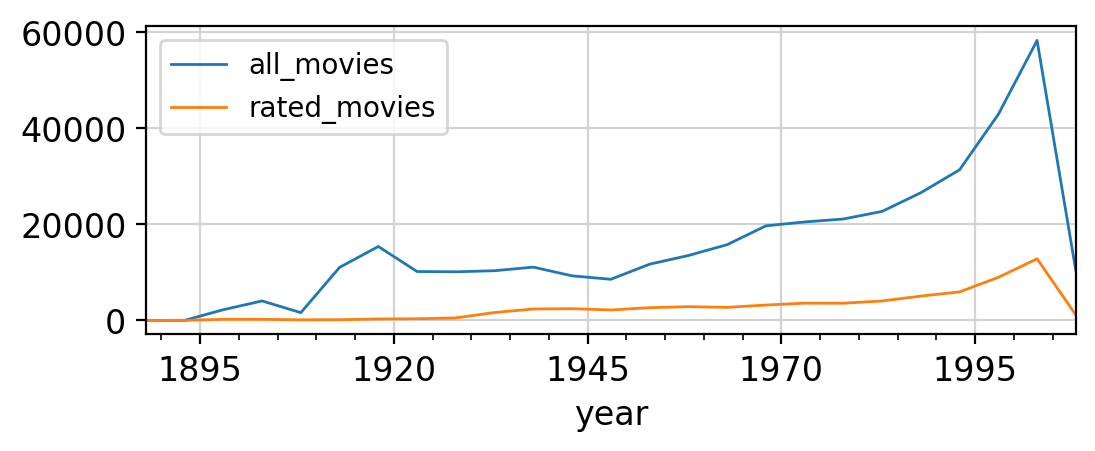

In [17]:
#create graph

df_movies.set_index('year').resample('5Y').sum().plot()



#Connect to the Facebook database, and use the MemberSince variable from the Profiles table to plot the growth of Facebook users. Use the following information:


(Learn something new) Use the cumsum() function of Pandas and plot the total number of registered users over time.

In [18]:
#setup connection to the database
conn_string_fb = 'mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
    user='student',
    password='dwdstudent2025',
    host = 'db.ipeirotis.org',
    port=3306,
    db='facebook',
    encoding = 'utf-8'
)
engine_fb = create_engine(conn_string_fb)

In [21]:
# create query and df

%%time
# Naive approach, fetch all the data first
query = 'SELECT * FROM Profiles'
with engine_fb.connect() as conn:
  df = pd.read_sql(text(query), con=conn)

pivot = df.pivot_table(
    index='MemberSince',
    values='ProfileID',
    aggfunc='count'
)
# Calculate weekly signups
weekly_signups = pivot.resample('1W').sum()

df_weekly_signups = weekly_signups.cumsum()

CPU times: user 699 ms, sys: 25.2 ms, total: 724 ms
Wall time: 754 ms


In [22]:
%%time
# Push calculations into SQL
query = '''
  SELECT MemberSince, COUNT(ProfileID) as signups
  FROM Profiles
  GROUP BY MemberSince
  ORDER BY MemberSince
'''
with engine_fb.connect() as conn:
  df = pd.read_sql(text(query), con=conn)
df.set_index("MemberSince", inplace=True)

CPU times: user 14.8 ms, sys: 1.97 ms, total: 16.8 ms
Wall time: 64.3 ms


<Axes: xlabel='MemberSince'>

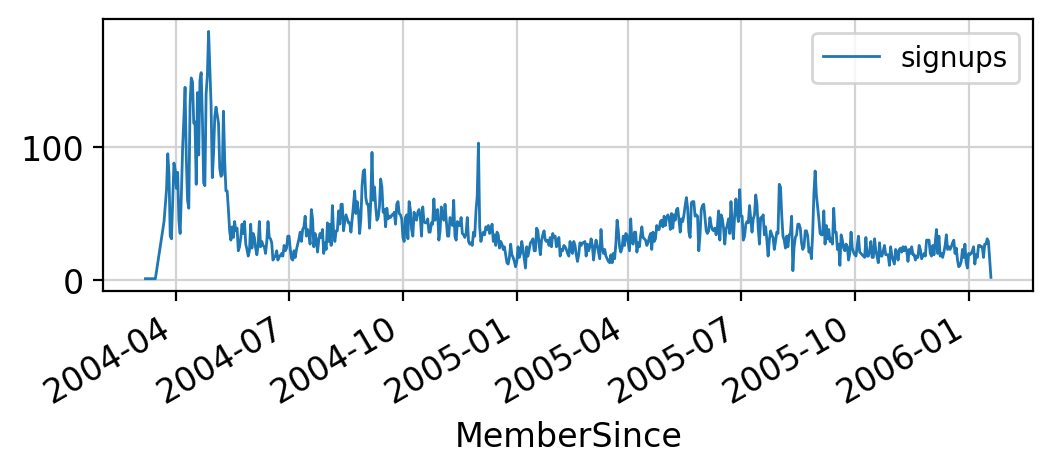

In [23]:
#reate graph
df.plot()

<Axes: xlabel='MemberSince'>

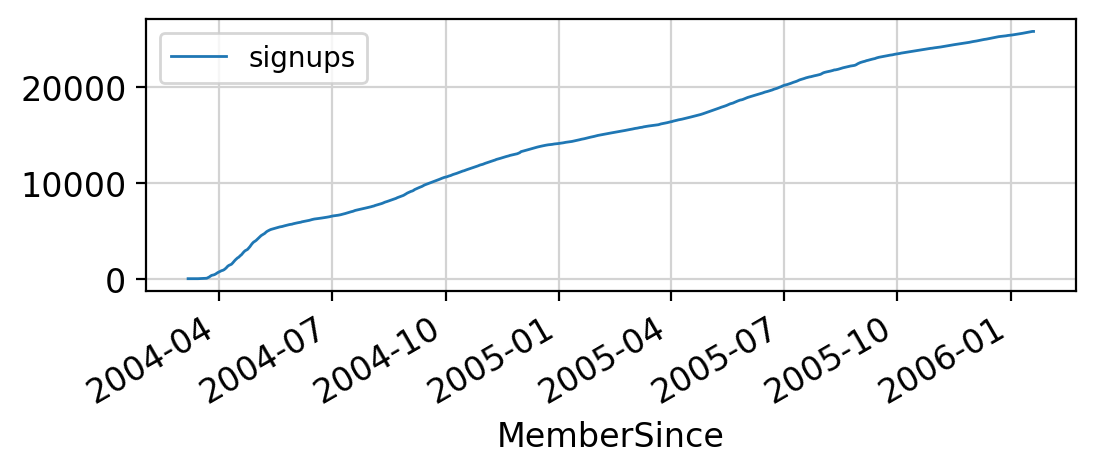

In [24]:
df.cumsum().plot()

<Axes: xlabel='MemberSince'>

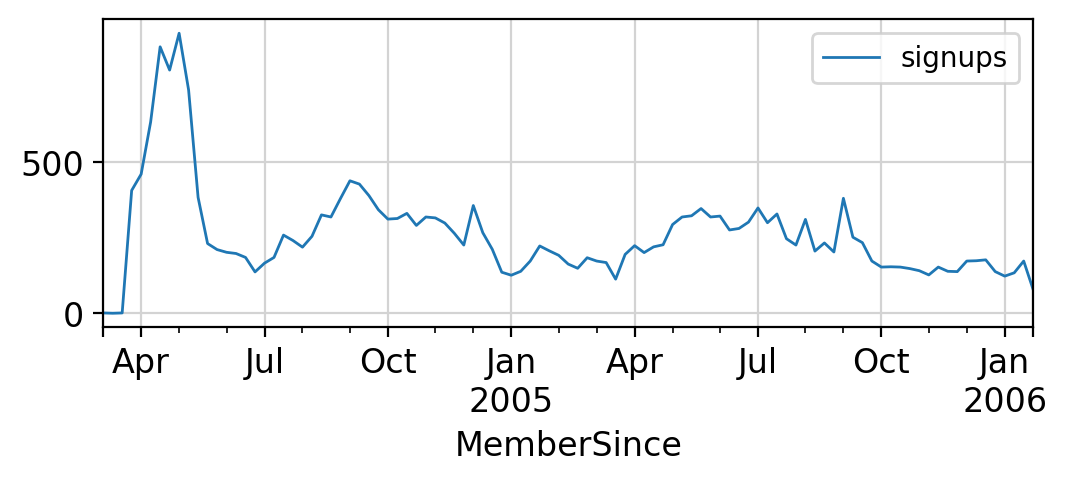

In [27]:
weekly_signups = df.resample('1W').sum()
weekly_signups.plot()